In [1]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

# add ../mcjax to the path
import sys
sys.path.append('../../')

#from mcjax.proba.dist import Dist
from mcjax.proba.neal_funnel import NealFunnel
from mcjax.mcmc.core import run_mcmc
from mcjax.mcmc.rwm import rwm_kernel



In [2]:
# initialize jax RNG
key = jr.key(0)

### Target concentratin in the neighbourhood of a sub-manifold


In [3]:
DIM = 5
dist = NealFunnel(dim=DIM)
logdensity = dist.logdensity

### Run RWM

In [5]:
kernel = rwm_kernel(logdensity, step_size=0.1,)
x_init = jnp.zeros(DIM)
state, params = kernel.init(x_init)
n_samples = 10_000
mcmc_output = run_mcmc(
                step=kernel.step,
                init_state=state,
                params=params,
                key=key,
                n_samples=n_samples,
                summarize=kernel.summarize)
traj = mcmc_output.traj
summary = mcmc_output.summary

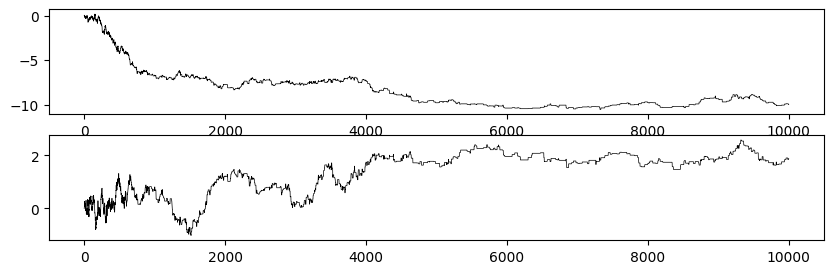

In [6]:
# plot x0 trajectory
plt.figure(figsize=(10, 3))
plt.subplot(2, 1, 1)
plt.plot(traj.x[:, 0], color='black', lw=0.5)
plt.subplot(2, 1, 2)
plt.plot(traj.x[:, 1], color='black', lw=0.5)

### Influence of the step size

In [9]:
# Define a function that samples a trajectory using RWM
def sample_RWM(key, x0, step_size, n_steps):
    # Create the RWM kernel
    kernel = rwm_kernel(logdensity=logdensity, step_size=step_size)
    
    # Initialize the state and parameters
    state, params = kernel.init(x0)
    
    # Run MCMC
    mcmc_output = run_mcmc(
        step=kernel.step,
        init_state=state,
        params=params,
        key=key,
        n_samples=n_steps,
        summarize=kernel.summarize
    )
    return mcmc_output

# JIT compile the sampler for a single trajectory
sample_RWM = jax.jit(sample_RWM, static_argnums=(3,)) 

# Define a batched version over multiple step sizes
sample_RWM_batch = jax.vmap(sample_RWM, in_axes=(None, None, 0, None))
sample_RWM_batch = jax.jit(sample_RWM_batch, static_argnums=(3,))


In [10]:
x0 = jnp.zeros(DIM)
step_size = 0.1
n_steps = 100_000
key, key_ = jr.split(key)
mcmc_output = sample_RWM(key_, x0, step_size, n_steps)

In [11]:
step_size_arr = 10.**np.linspace(-2, 1.5, 100)
n_steps = 1_000_000
mcmc_output_batch = sample_RWM_batch(key, x0, step_size_arr, n_steps)
traj_batch = mcmc_output_batch.traj
summary_batch = mcmc_output_batch.summary

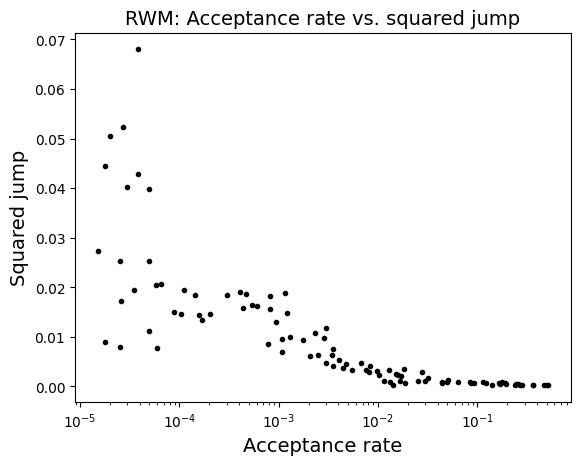

In [12]:
plt.plot(summary_batch.acceptance_rate, summary_batch.sq_jump, ".", color='black')
plt.xscale("log")
plt.xlabel("Acceptance rate", fontsize=14)
plt.ylabel("Squared jump", fontsize=14)
plt.title("RWM: Acceptance rate vs. squared jump", fontsize=14)

# find the optimal step size by maximizing the squared jump
index_opt = np.argmax(summary_batch.sq_jump)
optimal_step_size = step_size_arr[index_opt]
optimal_acceptance_rate = summary_batch.acceptance_rate[index_opt]

# --> unstable behavior --> has not mixed well